## Install Pytorch if needed

In [0]:
# http://pytorch.org/


# from os.path import exists
# from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
# platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
# cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
# accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

# !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
# import torch

In [0]:
import torch
import torch.nn as nn


class CenterLoss(nn.Module):
    """Center loss.
    
    Reference:
    Wen et al. A Discriminative Feature Learning Approach for Deep Face Recognition. ECCV 2016.
    
    Args:
        num_classes (int): number of classes.
        feat_dim (int): feature dimension.
    """
    def __init__(self, num_classes=10, feat_dim=2, use_gpu=True):
        super(CenterLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.use_gpu = use_gpu

        if self.use_gpu:
            self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim).cuda())
        else:
            self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim))

    def forward(self, x, labels):
        """
        Args:
            x: feature matrix with shape (batch_size, feat_dim).
            labels: ground truth labels with shape (batch_size).
        """
        batch_size = x.size(0)
        distmat = torch.pow(x, 2).sum(dim=1, keepdim=True).expand(batch_size, self.num_classes) + \
                  torch.pow(self.centers, 2).sum(dim=1, keepdim=True).expand(self.num_classes, batch_size).t()
        distmat.addmm_(1, -2, x, self.centers.t())

        classes = torch.arange(self.num_classes).long()
        if self.use_gpu: classes = classes.cuda()
        labels = labels.unsqueeze(1).expand(batch_size, self.num_classes)
        mask = labels.eq(classes.expand(batch_size, self.num_classes))

        dist = []
        for i in range(batch_size):
            value = distmat[i][mask[i]]
            value = value.clamp(min=1e-12, max=1e+12) # for numerical stability
            dist.append(value)
        dist = torch.cat(dist)
        loss = dist.mean()

        return loss

## Import modules

In [3]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np

print("Pytorch version:  " + str(torch.__version__))

use_cuda = torch.cuda.is_available()

print("Use CUDA: " + str(use_cuda))

Pytorch version:  0.4.1
Use CUDA: True


In [0]:
BATCH_SIZE = 64
BATCH_SIZE_TEST = 1000
EPOCHS = 50
LOG_INTERVAL = 10
NUM_OF_CLASSES = 10

## Dataset setup

In [0]:
torch.manual_seed(1)

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE_TEST, shuffle=True, **kwargs)

## Model setup

In [0]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        krnl_sz=3
        strd = 1
                    
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=krnl_sz, stride=strd, padding=1)
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=krnl_sz, stride=strd, padding=1)
        
        self.conv3 = nn.Conv2d(in_channels=50, out_channels=64, kernel_size=krnl_sz, stride=strd, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=krnl_sz, stride=strd, padding=1)
        
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=512, kernel_size=krnl_sz, stride=strd, padding=1)
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=krnl_sz, stride=strd, padding=1)

        self.prelu_weight = nn.Parameter(torch.Tensor(1).fill_(0.25))

        self.fc1 = nn.Linear(3*3*512, 3)
        self.fc3 = nn.Linear(3, 10)

    def forward(self, x):
        mp_ks=2
        mp_strd=2

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=mp_ks, stride=mp_strd)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, kernel_size=mp_ks, stride=mp_strd)

        x = F.relu(self.conv5(x))
        x = F.max_pool2d(x, kernel_size=mp_ks, stride=mp_strd)

        x = x.view(-1, 3*3*512) # Flatten

        features3d = self.fc1(x)
        x = F.prelu(features3d, self.prelu_weight)

        x = self.fc3(x)
        
        return x, features3d


In [7]:
model = Net()
model.eval()
# model.cuda()

Net(
  (conv1): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(50, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4608, out_features=3, bias=True)
  (fc3): Linear(in_features=3, out_features=10, bias=True)
)

In [0]:
### MODEL TEST RUN
# ind = 12
# image_tensor, label_tensor = test_loader.dataset[ind]
# image_tensor = image_tensor.reshape(1,1,28,28)
# image_tensor, label_tensor = image_tensor.to(device), label_tensor.to(device)

# prediction, features3d, features2d = model(image_tensor)
# prediction = np.argmax(prediction.detach().numpy())
# print ("\033[92m" + "PREDICTION : " + str(prediction) + "\033[0m")

# print("features3d:  " + str(features3d.detach().numpy()))
# print("features2d:  " + str(features2d.detach().numpy()))


## Train setup

In [0]:
def train(model, softmax_cross_entropy_loss, model_center_loss, device, train_loader, optimizer_model, optimizer_centloss, epoch):
    model.train()
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        outputs, features = model(data)
 
        weight_cent = 1.
        loss_softmax = softmax_cross_entropy_loss(outputs, labels)
        loss_cent = model_center_loss(features, labels)
        loss_cent *= weight_cent
        loss = loss_softmax + loss_cent
        
        optimizer_model.zero_grad()
        optimizer_centloss.zero_grad()
        loss.backward()
        optimizer_model.step()
        # by doing so, weight_cent would not impact on the learning of centers
        for param in model_center_loss.parameters():
            param.grad.data *= (1. / weight_cent)
        optimizer_centloss.step()
        
        
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, softmax_cross_entropy_loss, model_center_loss, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs,features = model(data)
#             test_loss += F.nll_loss(output, labels, reduction='sum').item() # sum up batch loss
            
            weight_cent = 1. # weight for center loss
  
            loss_softmax = softmax_cross_entropy_loss(outputs, labels)
            loss_cent = model_center_loss(features, labels)
            loss_cent *= weight_cent
            test_loss = loss_softmax + loss_cent

            pred = outputs.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(labels.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
  
#     bp()
#     print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct / len(test_loader.dataset)))

    print('\nTest set: Average loss: {}, Accuracy: {}/{} ({}%)\n'.format(
        str(test_loss), str(correct), str(len(test_loader.dataset)),
        str(100. * correct / len(test_loader.dataset))))

## Train process

In [9]:
from pdb import set_trace as bp

model = Net().to(device)
optimizer_model = optim.SGD(model.parameters(), lr=0.001, weight_decay=5e-04, momentum=0.9)

softmax_cross_entropy_loss = nn.CrossEntropyLoss()

model_center_loss = CenterLoss(num_classes=NUM_OF_CLASSES, feat_dim=3, use_gpu=use_cuda)
optimizer_centloss = torch.optim.SGD(model_center_loss.parameters(), lr=0.5)


for epoch in range(1, EPOCHS + 1):
    train(model, softmax_cross_entropy_loss, model_center_loss, device, train_loader, optimizer_model, optimizer_centloss, epoch)
    test(model, softmax_cross_entropy_loss, model_center_loss, device, test_loader)

torch.save(model.state_dict(),"mnist_cnn-center-loss2.pt")
torch.save(model_center_loss.state_dict(),"mnist_loss-center-loss2.pt")


Train Epoch: 39 [19200/60000 (32%)]	Loss: 0.024222
Train Epoch: 39 [19840/60000 (33%)]	Loss: 0.022248
Train Epoch: 39 [20480/60000 (34%)]	Loss: 0.026691
Train Epoch: 39 [21120/60000 (35%)]	Loss: 0.026971
Train Epoch: 39 [21760/60000 (36%)]	Loss: 0.038914
Train Epoch: 39 [22400/60000 (37%)]	Loss: 0.024916
Train Epoch: 39 [23040/60000 (38%)]	Loss: 0.024986
Train Epoch: 39 [23680/60000 (39%)]	Loss: 0.027412
Train Epoch: 39 [24320/60000 (41%)]	Loss: 0.039921
Train Epoch: 39 [24960/60000 (42%)]	Loss: 0.034264
Train Epoch: 39 [25600/60000 (43%)]	Loss: 0.018909
Train Epoch: 39 [26240/60000 (44%)]	Loss: 0.021724
Train Epoch: 39 [26880/60000 (45%)]	Loss: 0.047933
Train Epoch: 39 [27520/60000 (46%)]	Loss: 0.030179
Train Epoch: 39 [28160/60000 (47%)]	Loss: 0.024052
Train Epoch: 39 [28800/60000 (48%)]	Loss: 0.026114
Train Epoch: 39 [29440/60000 (49%)]	Loss: 0.029827
Train Epoch: 39 [30080/60000 (50%)]	Loss: 0.049268
Train Epoch: 39 [30720/60000 (51%)]	Loss: 0.035079
Train Epoch: 39 [31360/60000 (5

In [0]:
# # Download from COLAB
# from google.colab import files
# files.download('mnist_cnn-center-loss2.pt') 
# files.download('mnist_loss-center-loss2.pt') 


## Load Model

In [10]:
device = torch.device("cuda" if use_cuda else "cpu")
model = Net()
model.eval()
model.load_state_dict(torch.load("mnist_cnn-center-loss2.pt", map_location='cpu'))
model.to(device)

Net(
  (conv1): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(50, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4608, out_features=3, bias=True)
  (fc3): Linear(in_features=3, out_features=10, bias=True)
)

In [0]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

PREDICTION : 0
features3d:  [[ 0.25469062 -1.5374571  -0.89998955]]


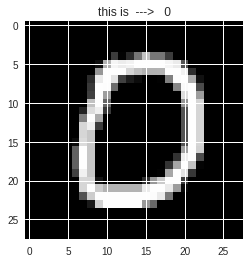

In [12]:
ind = 10

image = test_loader.dataset[ind][0].numpy().reshape(28,28)
lbl = test_loader.dataset[ind][1].numpy()
plt.title('this is  --->   ' + str(lbl))
plt.imshow(image, cmap='gray')


image_tensor, label_tensor = test_loader.dataset[ind]
image_tensor = image_tensor.reshape(1,1,28,28)
image_tensor, label_tensor = image_tensor.to(device), label_tensor.to(device)

prediction, features3d = model(image_tensor)
prediction = np.argmax(prediction.cpu().detach().numpy())
print ("\033[92m" + "PREDICTION : " + str(prediction) + "\033[0m")

print("features3d:  " + str(features3d.cpu().detach().numpy()))
# print("features2d:  " + str(features2d.cpu().detach().numpy()))


-----------

In [0]:
# Visualize train_data

In [14]:
f3d_train = []
lbls_train = []

for i in range(10000):
    image_tensor_train, label_tensor_train = train_loader.dataset[i]
    image_tensor_train = image_tensor_train.reshape(1,1,28,28)
    image_tensor_train, label_tensor_train = image_tensor_train.to(device), label_tensor_train.to(device)

    prediction_train, features3d_train = model(image_tensor_train)
    f3d_train.append(features3d_train[0].cpu().detach().numpy())

    prediction_train = np.argmax(prediction_train.cpu().detach().numpy())    
    lbls_train.append(prediction_train)

    
    
feat3d_train = np.array(f3d_train)
print("3d features train shape" + str(feat3d_train.shape))
lbls_train = np.array(lbls_train)
print("labels train shape" + str(lbls_train.shape))


3d features train shape(10000, 3)
labels train shape(10000,)


In [15]:
f3d_test = []
lbls_test = []

for i in range(10000):
    image_tensor_test, label_tensor_test = test_loader.dataset[i]
    image_tensor_test = image_tensor_test.reshape(1,1,28,28)
    image_tensor_test, label_tensor_test = image_tensor_test.to(device), label_tensor_test.to(device)

    prediction_test, features3d_test = model(image_tensor_test)
    f3d_test.append(features3d_test[0].cpu().detach().numpy())

    prediction_test = np.argmax(prediction_test.cpu().detach().numpy())    
    lbls_test.append(prediction_test)

    
    
feat3d_test = np.array(f3d_test)
print("3d features test shape" + str(feat3d_test.shape))
lbls_test = np.array(lbls_test)
print("labels test shape" + str(lbls_test.shape))


3d features test shape(10000, 3)
labels test shape(10000,)


# Visualize 2d

In [0]:
# import matplotlib.pyplot as plt
# %matplotlib inline

# f = plt.figure(figsize=(16,9))
# c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff', 
#      '#ff00ff', '#990000', '#999900', '#009900', '#009999']
# for i in range(10):
#     plt.plot(feat2d[lbls==i,0].flatten(), feat2d[lbls==i,1].flatten(), '.', c=c[i])
# plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

# plt.grid()
# plt.show()

# Visualize Train Data 3d

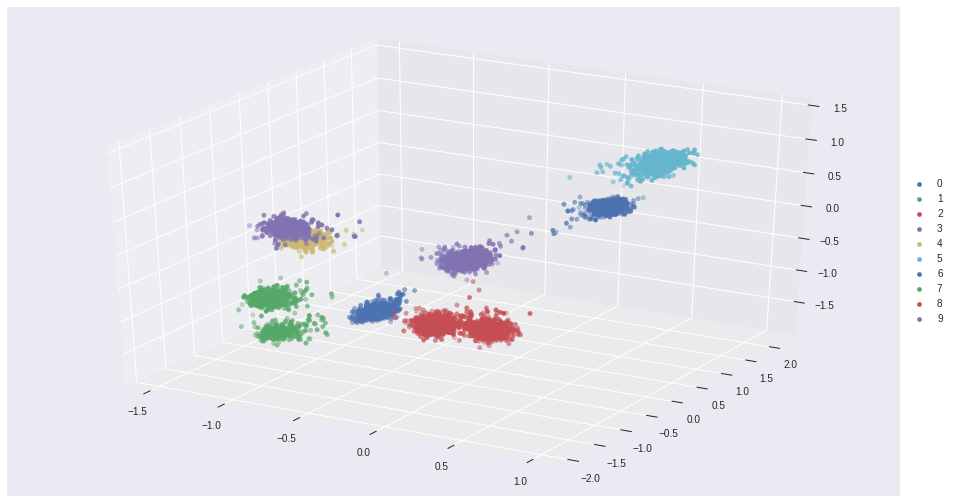

In [17]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(16,9))
ax = plt.axes(projection='3d')

for i in range(10):
    # Data for three-dimensional scattered points
    xdata = feat3d_train[lbls_train==i,2].flatten()
    ydata = feat3d_train[lbls_train==i,0].flatten()
    zdata = feat3d_train[lbls_train==i,1].flatten()
    ax.scatter3D(xdata, ydata, zdata);
ax.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

# Visualize Test Data 3d

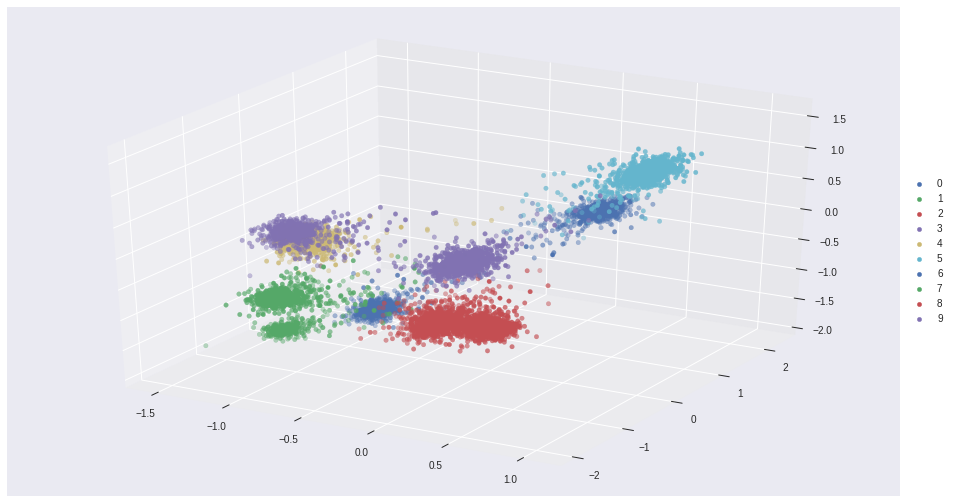

In [18]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(16,9))
ax = plt.axes(projection='3d')

for i in range(10):
    # Data for three-dimensional scattered points
    xdata = feat3d_test[lbls_test==i,2].flatten()
    ydata = feat3d_test[lbls_test==i,0].flatten()
    zdata = feat3d_test[lbls_test==i,1].flatten()
    ax.scatter3D(xdata, ydata, zdata);
ax.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()